### Submanifold Stabilization
9/3/24

In [4]:
import jax.numpy as jnp
import jax.scipy.linalg as jla
import jax.scipy as jsp
import numpy as np
import jax
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import dynamiqs as dq
import qutip as qt
import diffrax as df
from orthax.hermite import hermval
import strawberryfields as sf
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90'

In [5]:
jax.devices()

[CudaDevice(id=0)]

### Quantum Utils

### Basis Setup (OLD GARBAGE)
$\hbar = 1, m = 1, \omega = 1$

In [6]:
def onehot(len: int, ind: int):
    return jnp.zeros((len,)).at[ind].set(1)
def H_n(x: jax.Array, n: int):
    return hermval(x, onehot(n+1,n))
def Psi_n_analytic(x: jax.Array, n: int):
    return 1./jnp.sqrt(jnp.pow(2,n) * jsp.special.factorial(n)) * jnp.pow(1. / jnp.pi, .25) * jnp.exp(-x**2/2) * H_n(x=x, n=n)
def Psi_n_asymptotic(x: jax.Array, n: int): # https://en.wikipedia.org/wiki/Hermite_polynomials#Asymptotic_expansion
    approx_vals = jnp.zeros_like(x)
    for i in range(x.shape[0]):
        if x[i]**2 < 2*n:
            val = jnp.pow(1. / jnp.pi, .25) * jnp.pow(2*jnp.pi*n,-.25) * jnp.sqrt(2)* jnp.cos(x[i]*jnp.sqrt(2*n+1-x[i]**2/3) - n*jnp.pi/2)*jnp.pow(1 - x[i]**2/(2*n+1), -.25)
        # elif x[i] > jnp.sqrt(2*n): # https://arxiv.org/pdf/math/0601078
        #     sigma = jnp.sqrt(x[i]**2 - 2*n)
        #     print(f"{sigma=}")
        #     ex = (x[i]**2 - sigma*x[i] - n)/2. #+ n*jnp.log(sigma+x[i])
        #     print(f"{ex=}")
        #     val = jnp.exp(ex)*jnp.sqrt(.5*(1+x[i]/sigma))
        #     print(val)
        else:
            val = 0
        approx_vals = approx_vals.at[i].set(val)
    return jnp.nan_to_num(approx_vals)
def Psi_n(x: jax.Array, n: int):
    if n < 20:
        return Psi_n_analytic(x=x, n=n)
    else:
        return Psi_n_asymptotic(x=x, n=n)

In [7]:
def bra_n_ket_mu(code_zero: bool, n: int, Zcut: int, l_box: float, delta:float ):
    if code_zero:
        x_coords = jnp.linspace(-Zcut*l_box, Zcut*l_box,2*Zcut+1)
    else:
        x_coords = jnp.linspace((-Zcut+.5)*l_box,(Zcut+.5)*l_box, 2*Zcut + 1)
    Psi = Psi_n(x=x_coords, n=n)*jnp.exp(-n*delta**2)
    return jnp.sum(Psi)
def build_U(Ncut: int, Zcut: int = 40, l_box: float = 1, delta: float = .2):
    U = jnp.zeros((Ncut,2),dtype=complex)
    for i in range(Ncut):
        U = U.at[i,0].set(bra_n_ket_mu(code_zero=True, n=i, Zcut=Zcut, l_box=l_box, delta=delta))
        U = U.at[i,1].set(bra_n_ket_mu(code_zero=False, n=i, Zcut=Zcut, l_box=l_box, delta=delta))
    return U    

#### Function Verification

[]

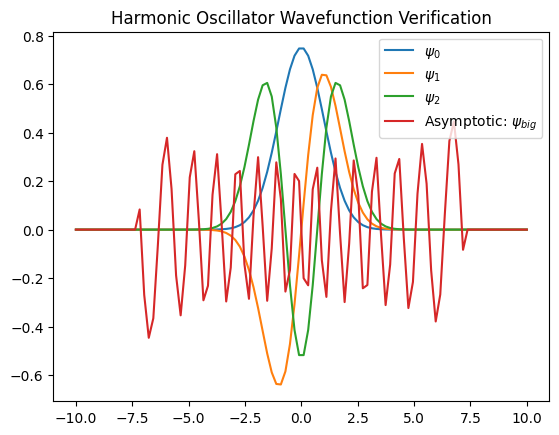

In [8]:
xspace = jnp.linspace(-10,10,100)

plt.plot(xspace, Psi_n(xspace, 0), label=r"$\psi_0$")
plt.plot(xspace, Psi_n(xspace, 1), label=r"$\psi_1$")
plt.plot(xspace, Psi_n(xspace, 2), label=r"$\psi_2$")

bign = 27
plt.plot(xspace, Psi_n(xspace, bign), label=r"Asymptotic: $\psi_{big}$")

plt.title("Harmonic Oscillator Wavefunction Verification")
plt.legend()
plt.plot()

### Basis Setup

In [9]:
nmodes = 1
hbar = 1
N_cut = 100

prog_gkp_fock = sf.Program(nmodes)
with prog_gkp_fock.context as q:
    sf.ops.GKP(state=[0,0]) | q

eng = sf.Engine("fock", backend_options={"cutoff_dim": N_cut, "hbar": hbar})
logical_zero = jnp.array(eng.run(prog_gkp_fock).state.data).reshape((N_cut,1))

prog_gkp_fock2 = sf.Program(nmodes)
with prog_gkp_fock2.context as q:
    sf.ops.GKP(state=[np.pi,0]) | q
logical_one = jnp.array(eng.run(prog_gkp_fock2).state.data).reshape((N_cut,1))
U = jnp.hstack((logical_zero,logical_one))
U_dag = dq.dag(U)
U_ident = U_dag@U
U_proj = U@U_dag


In [10]:
def Pi(rho):
    return U_proj@rho@U_proj
def Pi_perp(rho):
    return rho - Pi(rho)
def Pidot_2(sigma_dot):
    return .5*(dq.sigmax() * dq.trace(dq.sigmax() @ sigma_dot) +
            dq.sigmay() * dq.trace(dq.sigmay() @ sigma_dot) + 
            dq.sigmaz() * dq.trace(dq.sigmaz() @ sigma_dot))
def Pidot(rho_dot):
    return U@Pidot_2(U_dag@rho_dot@U)@U_dag
def Pidot_perp_N(rho_dot):
    return rho_dot - Pidot(rho_dot)

In [11]:
def psi_C(theta: float, phi: float):
    return jnp.cos(theta/2.)*logical_zero + jnp.exp(1j*phi)*jnp.sin(theta/2.)*logical_one
def rho_C(theta:float, phi: float):
    return dq.todm(psi_C(theta=theta,phi=phi))
def add_rho_to_bloch(rho, blocher):
    sigma = U_dag @ rho @ U
    vec = dq.expect([dq.sigmax(), dq.sigmay(), dq.sigmaz()], sigma)
    blocher.add_vectors(vec)

#### Projection Tests

In [12]:
rho_A = rho_C(0,0)
rho_B = Pi(rho_A)
print(dq.trace(rho_A))
print(dq.trace(rho_B))
print(np.max(rho_A-rho_B))
print(np.max(rho_A - (rho_B + Pi_perp(rho_A))))
print(dq.trace(rho_C(0,0)@rho_C(jnp.pi,0)))
print(dq.trace(rho_A@rho_A))
cohere = dq.coherent_dm(N_cut, 4)
print(dq.trace(cohere@rho_A))

(1+0j)
(1.0042024+0j)
(0.021137059+0j)
(1.5314827e-25+0j)
(0.0014007846+0j)
(1.0000001+0j)


RuntimeError: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error

#### Plotting

In [ ]:
b = qt.Bloch()
add_rho_to_bloch(rho_A, b) # 0
add_rho_to_bloch(rho_B, b) # 0 off by a bit
add_rho_to_bloch(rho_C(jnp.pi,0),b) # 1
add_rho_to_bloch(rho_C(jnp.pi/2,jnp.pi/2.),b) # y
b.show()

NameError: name 'qt' is not defined

### Optimal Controlling GKP

In [ ]:
# states
rho_0 = dq.fock_dm(N_cut, 0) # vac to start
# goal: Pidot_perp_N = 0 forall t ie not leaving codespace

# operators
a = dq.destroy(N_cut)
a_dag = dq.create(N_cut)
n = dq.number(N_cut)
x = 1/jnp.sqrt(2)*(a + a_dag)
p = 1j/jnp.sqrt(2)*(a_dag - a)

# Dissipators, uncontrollable
gamma_0 = .1
U_0 = jnp.sqrt(gamma_0) * a # photon loss
gamma_1 = .01
U_1 = jnp.sqrt(gamma_1) * n # dephasing

# Dissipators, controllable
C_0 = 0 # TODO

# Hamiltonians
H_0 = dq.eye(N_cut) # drift
H_1 = jnp.sqrt(2) * x # control 1 (displacement part 1)
H_2 = jnp.sqrt(2) * p # control 2 (displacement part 2)